# 3 Qubit GHZ Generation
- This demo shows how Lightwords can be utilized for the qubit based paradigm of quantum computing.

In [1]:
import lightworks as lw
from lightworks import emulator, State

import numpy as np
import matplotlib.pyplot as plt

## Theory

In the following we show a demonstration of the implementation of two successive CNOTs across 3 qubits to generate the 3 photon entangled GHZ state $\frac{1}{\sqrt{2}}(\ket{000} + \ket{111})$.

In qubit language we start with the state $\ket{000}$, a hadamard is then applied to the first qubit, this gives: 

\begin{equation} H_1\ket{000} = \frac{1}{\sqrt{2}}(\ket{000} + \ket{100}) \tag{1} \end{equation}

On application of the first CNOT between qubits 1 and 2, the state is then transformed into:

\begin{equation} CNOT_{1,2}\;\frac{1}{\sqrt{2}}(\ket{000} + \ket{100}) = \frac{1}{\sqrt{2}}(\ket{000} + \ket{110}) \tag{2} \end{equation}

Then, on application of the second CNOT between qubits 2 and 3, we get the GHZ state:

\begin{equation} CNOT_{2,3}\;\frac{1}{\sqrt{2}}(\ket{000} + \ket{110}) = \frac{1}{\sqrt{2}}(\ket{000} + \ket{111}) \tag{3} \end{equation}

## Circuit
- We can create the circuit described with the code in the cell below.
- The included lightworks qubit components to simplify the construction, abstracting the required heralds of the circuit..

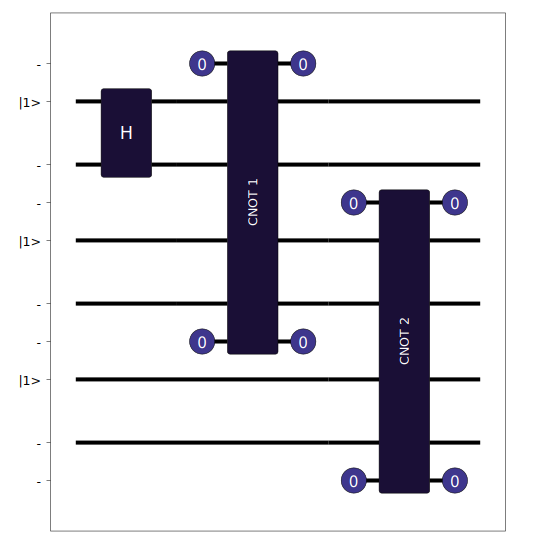

In [2]:
# Define cnot and H components
cnot_circuit = lw.qubit.CNOT()
h_circuit = lw.qubit.H()

# We will then define the larger overall circuit - 3 qubits so 6 modes
circuit = lw.Circuit(6)

# First add the initial Hadamard (H) gate which acts on qubit 1.
circuit.add(h_circuit)
# Then include the first CNOT, grouping all components
circuit.add(cnot_circuit, 0, group = True, name = f"CNOT 1")
# Then add second CNOT
circuit.add(cnot_circuit, 2, group = True, name = f"CNOT 2")

# Use display method, we will assign mode labels which allow us to mark which
# mode the photons should be input on
circuit.display(display_type = "svg", 
                mode_labels = ['|1>','-','|1>','-','|1>','-'])

## Simulation with perfect system
- We can then simulate the system to check the expected output.
- Before simulation, we will define a processing function to convert the results - the exact details of what this does are not too important, it just switches between the photon and qubit representations.

In [3]:
def process_cnot_data(data):
    # Convert mode data into qubit form
    converted_results = {}
    for s, p in data.items():
        conv_state = ""
        for i in range(0, len(s), 2):
            if s[i:i+2] == State([1,0]):
                conv_state += "0"
            elif s[i:i+2] == State([0,1]):
                conv_state += "1"
            else:
                conv_state += "X"
        converted_results[conv_state] = p
    return converted_results

- As part of the simulation, we will define what is known as a post-slection function. 
- This means that we will only accept outputs for which this particular rule is true.
- We then use the Sampler again to find the outputs from the system.
- As heralds were included in the original circuit we do not need to specify these modes.

In [4]:
sampler = emulator.Sampler(circuit, State([1,0,1,0,1,0]))

# Define post-selection and get results
post_select = lambda s: sum(s[0:2]) == 1 and sum(s[2:4]) == 1 and sum(s[4:6]) == 1
results = sampler.sample_N_inputs(100000, post_select = post_select, seed = 1)
# Process with function
converted_results = process_cnot_data(results)

- These results can then be plotted.
- We see the two expected measurement outcomes for the state $\frac{1}{\sqrt{2}}(\ket{000} + \ket{111})$.

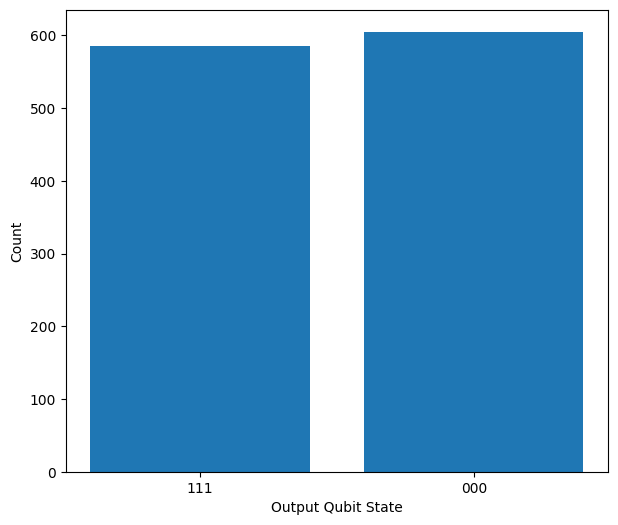

In [5]:
plt.figure(figsize = (7,6))
plt.bar(range(len(converted_results)), converted_results.values())
plt.xticks(range(len(converted_results)), converted_results.keys())
plt.xlabel("Output Qubit State")
plt.ylabel("Count")
plt.show()

## Simulation with imperfect source and detectors
- Unfortunately, the components of our system are not perfect, and these imperfections will alter the results we see.
- Luckily, we can simulate and understand this with the emulator.
- To do this we will modify some of the attributes of the Sampler object to account for imperfections in the single photon source and detector modules of the system.

In [6]:
sampler.source = emulator.Source(indistinguishability = 0.98, purity = 0.98)
sampler.detector = emulator.Detector(efficiency = 0.8, p_dark = 1e-6)

- Can then re-calculate the results. (This may take a few seconds.)

In [7]:
# Define post-selection and get results
post_select = lambda s: sum(s[0:2]) == 1 and sum(s[2:4]) == 1 and sum(s[4:6]) == 1
results = sampler.sample_N_inputs(100000, post_select = post_select, seed = 1)
# Process with function
converted_results = process_cnot_data(results)

- And plot. Here we see some states other than the 000 and 111 outputs we wanted, demonstrating the potential effect of errors within the system.

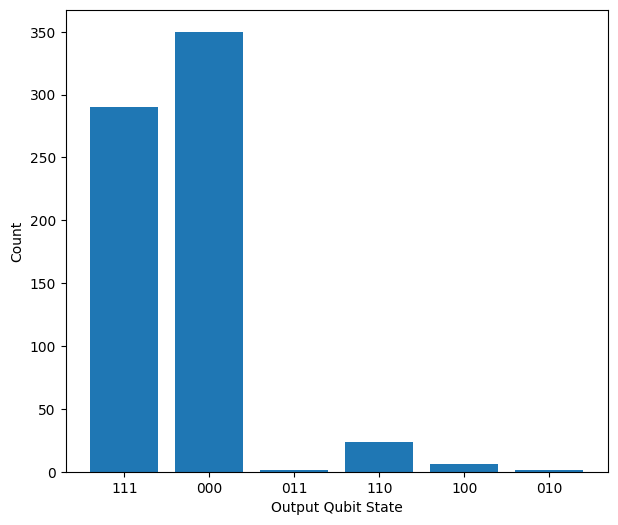

In [8]:
plt.figure(figsize = (7,6))
plt.bar(range(len(converted_results)), converted_results.values())
plt.xticks(range(len(converted_results)), converted_results.keys())
plt.xlabel("Output Qubit State")
plt.ylabel("Count")
plt.show()